In [1]:
import numpy as np
from matplotlib import pyplot as plt

plt.rcParams["font.size"] = 16

import qiskit.pulse as pulse
from qiskit.quantum_info.states import Statevector
from qiskit.quantum_info.operators import Operator

from qiskit_dynamics import Solver, Signal
from qiskit_dynamics.pulse import InstructionToSignals

## \begin{align} 
H_\text{drift} &= \frac{\omega}{2} Z\\
\nonumber \\
H_\text{drive}(t) &= \frac{r\,\Omega(t)}{2} X 
\end{align}


In [15]:
Omega_01 = 5.508 #Ghz
Delta = - 0.25
Omega_02 = 2*Omega_01 + Delta
Lambda = np.sqrt(2)/50

ket0 = np.array([[1,0,0]]).T
ket1 = np.array([[0,1,0]]).T
ket2 = np.array([[0,0,1]]).T

sigma_m1 = ket0 @ ket1.T.conj()
sigma_m2 = ket1 @ ket2.T.conj()

sigma_p1 = sigma_m1.T.conj()
sigma_p2 = sigma_m2.T.conj()

P0, P1, P2 = ket0 @ ket0.T.conj(), ket1 @ ket1.T.conj(), ket2 @ ket2.T.conj()


In [16]:
drift = 2 * np.pi * (Omega_01*P1 + Omega_02*P2)
control = [2 * np.pi * (sigma_p1 + sigma_m1 + Lambda*(sigma_p2 + sigma_m2))]
R_frame = 2 * np.pi * (Omega_01*P1 + 2*Omega_01*P2)
drift, control, R_frame

(array([[ 0.        ,  0.        ,  0.        ],
        [ 0.        , 34.60778467,  0.        ],
        [ 0.        ,  0.        , 67.64477302]]),
 [array([[0.        , 6.28318531, 0.        ],
         [6.28318531, 0.        , 0.17771532],
         [0.        , 0.17771532, 0.        ]])],
 array([[ 0.        ,  0.        ,  0.        ],
        [ 0.        , 34.60778467,  0.        ],
        [ 0.        ,  0.        , 69.21556934]]))

In [36]:
y0 = Statevector([1., 0., 0.])
dt = 0.222
sigma = 3*Omega_01/2 / 10
T = 2*4*sigma
duration = np.math.ceil(T / dt)

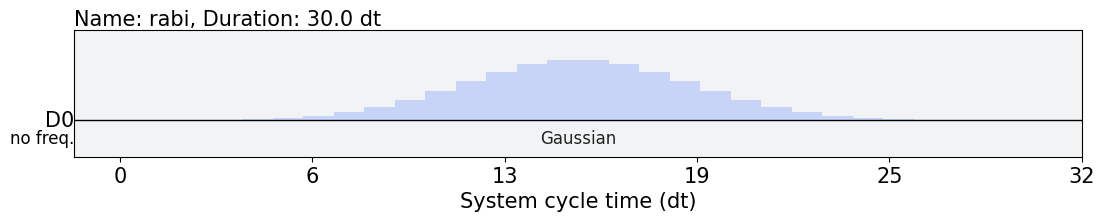

In [37]:
# signals = [Signal(envelope=1., carrier_freq=5.508)]
with pulse.build(name="rabi") as rb:
    pulse.play(pulse.Gaussian(duration=duration, amp=1, sigma=sigma / dt), pulse.DriveChannel(0))
rb.draw()

In [38]:
# construct the solver
hamiltonian_solver = Solver(
    static_hamiltonian=drift,
    hamiltonian_operators=control,
#     rotating_frame=drift,
#     rwa_cutoff_freq=2 * 5.0,
    hamiltonian_channels=["d0"],
    channel_carrier_freqs={"d0": Omega_01},
    dt=dt,
)

In [33]:
# converter = InstructionToSignals(dt, carriers={"d0": 5.5})
# signals = converter.get_signals(rb)

In [39]:
sol = hamiltonian_solver.solve(t_span=[0., T], y0=y0, signals=rb)

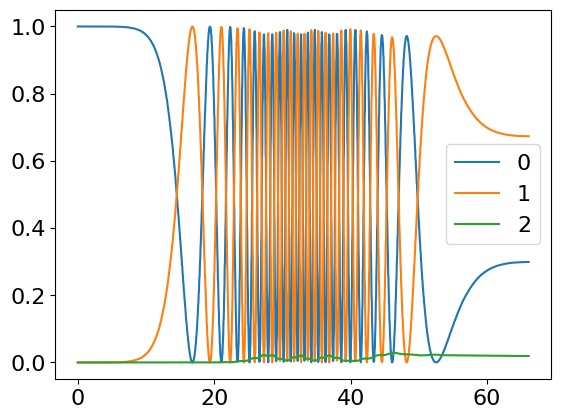

In [29]:
plt.plot(sol.t, np.array([psi.probabilities() for psi in sol.y])[:,0], label='0')
plt.plot(sol.t, np.array([psi.probabilities() for psi in sol.y])[:,1], label='1')
plt.plot(sol.t, np.array([psi.probabilities() for psi in sol.y])[:,2], label='2')
plt.legend()

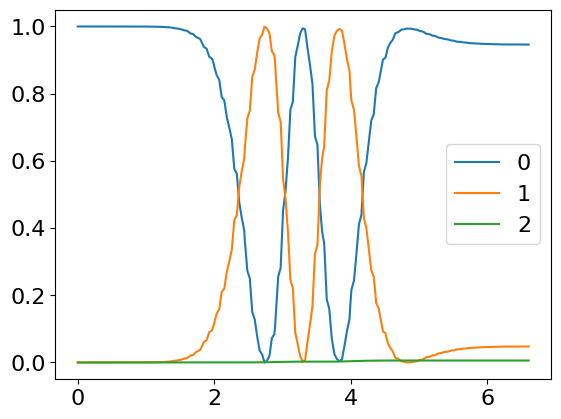

In [40]:
plt.plot(sol.t, np.array([psi.probabilities() for psi in sol.y])[:,0], label='0')
plt.plot(sol.t, np.array([psi.probabilities() for psi in sol.y])[:,1], label='1')
plt.plot(sol.t, np.array([psi.probabilities() for psi in sol.y])[:,2], label='2')
plt.legend()

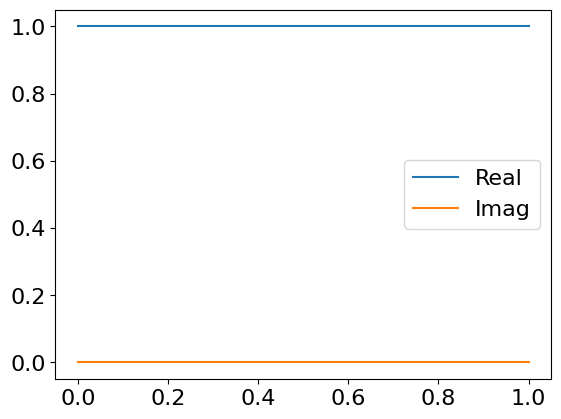

In [40]:
signals[0].draw(0,1,1000,'envelope')

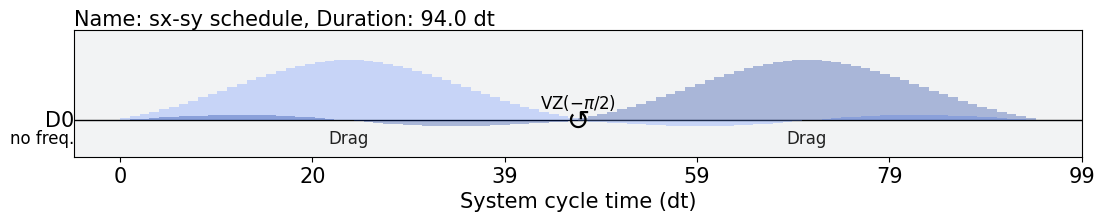

In [28]:
r = 0.1  # Strength of the Rabi-rate in GHz.

# w = 5.0  # Frequency of the qubit transition in GHz.

dt = 0.222  # Sample rate of the backend in ns.

# Define gaussian envelope function to have a pi rotation.
amp = 1.5
area = 1
sig = area * 0.399128 / r / amp
T = 4 * sig
duration = int(T / dt)
beta = 2.0

# The 1.75 factor is used to approximately get a sx gate.
# Further "calibration" could be done to refine the pulse amplitude.
with pulse.build(name="sx-sy schedule") as xp:
    
    pulse.play(pulse.Drag(duration, amp / 1.75, sig / dt, beta), pulse.DriveChannel(0))
    pulse.shift_phase(np.pi / 2, pulse.DriveChannel(0))
    pulse.play(pulse.Drag(duration, amp / 1.75, sig / dt, beta), pulse.DriveChannel(0))

xp.draw()

In [29]:
converter = InstructionToSignals(dt, carriers={"d0": Omega_01})
signals = converter.get_signals(xp)

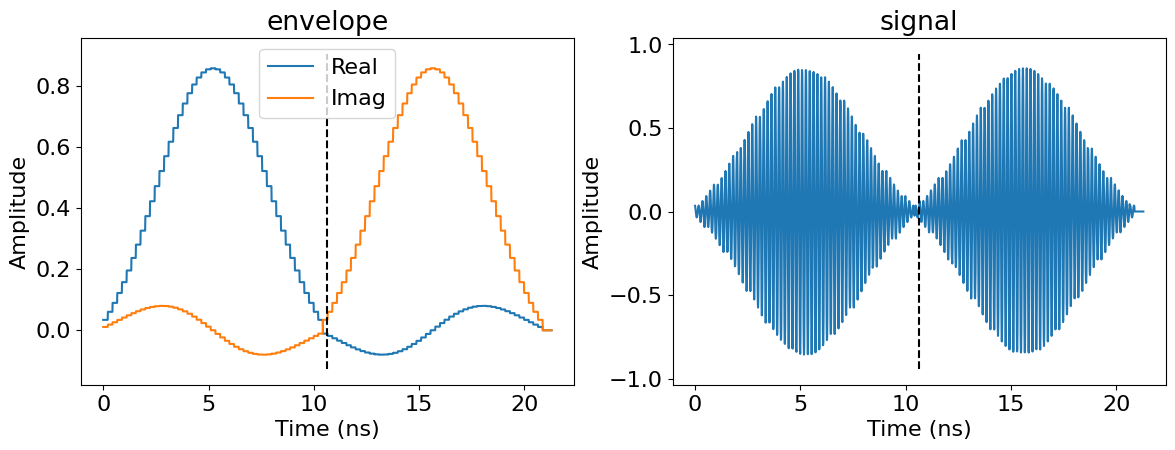

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(14, 4.5))
for ax, title in zip(axs, ["envelope", "signal"]):
    signals[0].draw(0, 2 * T, 2000, title, axis=ax)
    ax.set_xlabel("Time (ns)")
    ax.set_ylabel("Amplitude")
    ax.set_title(title)
    ax.vlines(T, ax.get_ylim()[0], ax.get_ylim()[1], "k", linestyle="dashed")

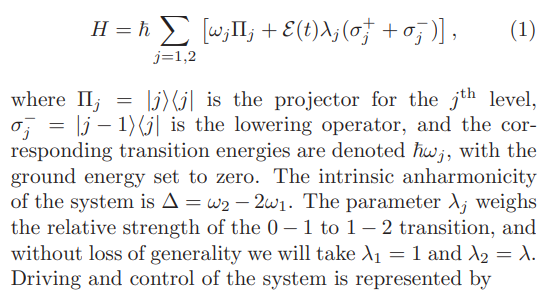

In [33]:
# # construct operators
# X = Operator.from_label("X")
# Z = Operator.from_label("Z")

# drift = 2 * np.pi * w * Z / 2
# operators = [2 * np.pi * r * X / 2]

In [35]:
# Start the qubit in its ground state.
y0 = ket0

# def solve(T_mul):
#     result = hamiltonian_solver.solve(t_span=[0., T_mul], y0=y0, signals=signals, t_eval=np.linspace(0, T_mul, 100))
#     return result.t, result.y

# fast_solve = jit(solve, static_argnames='T_mul')
# sol = fast_solve(5*T)

sol = hamiltonian_solver.solve(t_span=[0., T], y0=y0, signals=signals)#, atol=1e-8, rtol=1e-8)

In [36]:
def plot_populations(sol):
    pop0 = [(np.abs(psi)**2)[0] for psi in sol.y]
    pop1 = [(np.abs(psi)**2)[1] for psi in sol.y]

    fig = plt.figure(figsize=(8, 5))
    plt.plot(sol.t, pop0, lw=3, label="Population in |0>")
    plt.plot(sol.t, pop1, lw=3, label="Population in |1>")
    plt.xlabel("Time (ns)")
    plt.ylabel("Population")
    plt.legend(frameon=False)
    plt.ylim([0, 1.05])
#     plt.xlim([0, 2*T])
    plt.vlines(T, 0, 1.05, "k", linestyle="dashed")

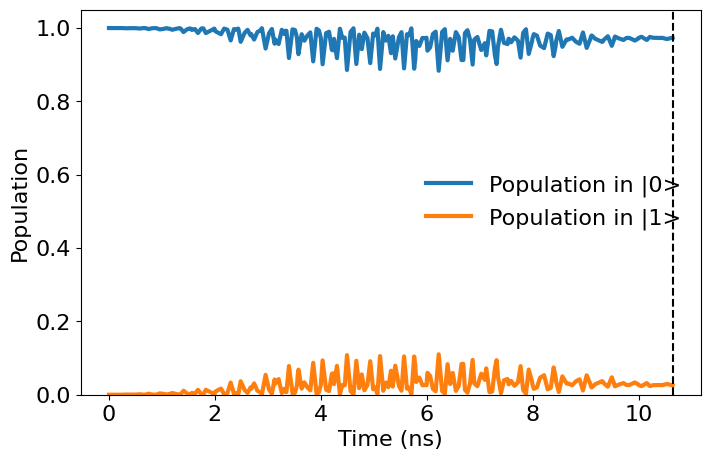

In [37]:
plot_populations(sol)

In [32]:
%timeit _ = solve(5*T)

1.97 s ± 67.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [33]:
%timeit _ = fast_solve(5*T)

9.56 ms ± 496 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
